<a href="https://colab.research.google.com/github/RuslanFF1968/Pioneer/blob/main/Complex_analysis_and_forecast_through_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import of libraries


In [ ]:
import numpy as np #Библиотека работы с массивами
import pandas as pd # Библиотека для работы с базами

from tensorflow.keras.models import Sequential, Model #
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten #
from tensorflow.keras import utils #Используем для to_categoricall
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop #
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence #
from tensorflow.keras.preprocessing.sequence import pad_sequences #
from tensorflow.keras.callbacks import LambdaCallback # подключаем колбэки

from sklearn.preprocessing import StandardScaler #
from sklearn.model_selection import train_test_split # Для разбивки на выборки
from sklearn.metrics import mean_squared_error, mean_absolute_error #
#from google.colab import files #Для загрузки своей картинки

import random #Для генерации случайных чисел
import math # Для округления
#import os #Для работы с файлами
import re #
import matplotlib.pyplot as plt #
%matplotlib inline

from IPython.display import clear_output


In [ ]:
from google.colab import drive # Подключаем диск
drive.mount('/content/drive')

Mounted at /content/drive


Осторожно! Запуск всех разделов сразу, может привести к недостатку памяти и сессия перезапустится.

# Wage estimate using the HeadHunter DB

## DB loading and content review

In [ ]:
fixed_df = pd.read_csv('/content/drive/MyDrive/Базы/hh_fixed.csv')# Это то, куда вы скачали файл

In [ ]:
# Количество резюме и критерии
print(fixed_df.shape)

(62967, 13)


In [ ]:
fixed_df.head()

,Unnamed: 0,"Пол, возраст",ЗП,Ищет работу на должность:,Город,Занятость,График,Опыт (двойное нажатие для полной версии),Последенее/нынешнее место работы,Последеняя/нынешняя должность,Образование и ВУЗ,Обновление резюме,Авто
0,0,"Мужчина , 29 лет , родился 16 мая 1989",40000 руб.,Специалист по поддержке чата(support team) дом...,"Новороссийск , готов к переезду (Анапа, Геленд...",полная занятость,полный день,Опыт работы 3 года 9 месяцев Специалист по по...,"ООО ""Гольфстрим""",Генеральный директор,Высшее образование 2011 Международный юридиче...,26.04.2019 08:04,Не указано
1,1,"Мужчина , 38 лет , родился 25 мая 1980",40000 руб.,Системный администратор,"Новосибирск , м. Березовая роща , не готов к ...",полная занятость,полный день,Опыт работы 11 лет 11 месяцев Системный админ...,ООО «Завод модульных технологий»,Системный администратор,Высшее образование 2002 Новосибирский государс...,26.04.2019 04:30,Не указано
2,2,"Мужчина , 35 лет , родился 14 июня 1983",300000 руб.,DevOps TeamLead / DevOps архитектор,"Москва , готов к переезду , готов к редким ком...",полная занятость,полный день,Опыт работы 12 лет 11 месяцев DevOps TeamLead...,Банк ВТБ (ПАО),Начальник отдела методологии разработки (DevOp...,DevOps TeamLead / DevOps архитектор 300 000 ру...,09.04.2019 14:40,Не указано
3,3,"Мужчина , 33 года , родился 2 августа 1985",180000 руб.,Руководитель IT отдела,"Москва , м. Щукинская , не готов к переезду ,...","частичная занятость, полная занятость","удаленная работа, полный день",Опыт работы 15 лет 10 месяцев Руководитель IT...,"""Ай-Теко"", ведущий российский системный интегр...",Старший системный администратор,Руководитель IT отдела 180 000 руб. Информацио...,09.04.2019 14:39,Имеется собственный автомобиль
4,4,"Мужчина , 22 года , родился 1 сентября 1996",40000 руб.,Junior Developer,"Москва , м. Юго-Западная , не готов к переезд...","стажировка, частичная занятость, проектная работа","гибкий график, удаленная работа",Опыт работы 1 год 1 месяц Junior Developer 40...,R-Style SoftLab,Менеджер IT-проектов,Junior Developer 40 000 руб. Информационные те...,29.03.2019 12:40,Не указано


In [ ]:
# Пример данных
n = 0 # Берем первое резюме
for i in range(len(fixed_df.values[n])): # Выводим значение каждой графы резюме
  print(i, " ", fixed_df.values[n][i])

0   0
1   Мужчина ,  29 лет , родился 16 мая 1989
2   40000 руб.
3   Специалист по поддержке чата(support team) домашний агент
4   Новороссийск , готов к переезду (Анапа, Геленджик) , не готов к командировкам
5   полная занятость
6   полный день
7   Опыт работы 3 года 9 месяцев  Специалист по поддержке чата(support team) домашний агент 40 000 руб. Информационные технологии, интернет, телеком Системный администратор Сотовые, Беспроводные технологии Телекоммуникации Занятость: полная занятость График работы: полный день Опыт работы 3 года 9 месяцев Май 2012 — Январь  2016 3 года 9 месяцев ООО "Гольфстрим" Республика Башкортостан Строительство, недвижимость, эксплуатация, проектирование ... Строительство жилищное Управление и эксплуатация недвижимости Генеральный директор Руководство, отладка деловых связей, заключение договоров, развитие организации Ключевые навыки Теперь резюме открыто всему интернету — изменить можно в настройках видимости. Заключение договоров Деловое общение Деловая 

## DB parsing



In [ ]:
##############################################
####Убрать кодировку в описаниях \xa0 \n
##############################################
fixed_df = fixed_df.drop(fixed_df.columns[0],axis = 1) # Убираем первый столбец с продублированными индексами. Он нам не нужен

i=0
for j in range(12):  # Для каждого из столбцов таблицы
    for i in range(fixed_df.shape[0]): # По всем резюме
        if type(fixed_df.values[i][j])!=float: # если данные текстовые, то заменяем фрагменты кодировки ASCII на отсутствие символов
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\xa0","")
            fixed_df.values[i][j] = fixed_df.values[i][j].replace("\n"," ")

In [ ]:
# Данные о поле и возрасте
def getParameterSexAge(arg):
  out = [0,0]
  #Если М, то 1. По умолчанию 0 - Ж
  if "М" in arg:
    out[0] = 1
  # текущий год - год рождения
  year_tec = 2020
  if (len(arg) > 7):
    out[1] = year_tec - int(re.findall(r'\d{4}', arg)[0])
  return out

# Полученный возраст превращаем в класс возрастной категории
def getParameterAgeVect(arg):
  outClass =int((arg-13)/5)
  outClass = max(0, min(10,outClass))
  # На выходе получаем вектор с нужной категорией возраста
  return list(utils.to_categorical(outClass, 11).astype('int'))


# Зарплата
def getParameterSalary(arg):
    num = arg
    # Сначала получаем чистое число, убираем лишние знаки
    if (type(num) == str):
        num = re.sub(' ','',num)
        num = re.sub('[а-яА-ЯёЁ]','',num)
        num = re.sub('[a-zA-Z]','',num)
        num = num.replace('.','')

        # Получаем чисто валюту, убираем цифры
        curr = re.sub('[0-9]','',arg)
        curr = curr.replace('.','').strip()

        # Конвертируем в рубли, если валюта
        if curr == 'USD':
           num = float(num)*65
        elif curr == 'KZT':
           num = float(num)*0.17
        elif curr=='грн':
           num = float(num)*2.6
        elif curr=='белруб':
           num = float(num)*30.5
        elif curr=='EUR':
           num = float(num)*70
        elif curr=='KGS':
           num = float(num)*0.9
        elif curr=='сум':
           num = float(num)*0.007
        elif curr=='AZN':
           num = float(num)*37.5

    salaryStr = int(num)


    return salaryStr


# Данные о городе
def getParameterCity(arg):
  millionCities = "Новосибирск Екатеринбург Нижний Новгород Казань Челябинск Омск Самара Ростов-на-Дону Уфа Красноярск Пермь Воронеж Волгоград"
  sarg=arg.split(',')
  for item in sarg:
    item= item.strip()
    if item == "Москва":          return [1, 0, 0, 0]
    if item == "Санкт-Петербург": return [0, 1, 0, 0]
    if item in millionCities:     return [0, 0, 1, 0]
  return [0, 0, 0, 1]

# Данные о желаемой занятости
def getParameterEmployment(arg):
  out= [0, 0, 0, 0]
  if ("стажировка" in arg):           out[0]=1
  if ("частичная занятость" in arg):  out[1]=1
  if ("проектная работа" in arg):     out[2]=1
  if ("полная занятость" in arg):     out[3]=1
  return out

# Данные о желаемом графике работы
def getParameterSchedule(arg):
  out = [0, 0, 0, 0]
  if ("гибкий график" in arg):    out[0]=1
  if ("полный день" in arg):      out[1]=1
  if ("сменный график" in arg):   out[2]=1
  if ("удаленная работа" in arg): out[3]=1
  return out

# Данные об образовании
def getParameterEducation(arg):
  out = [0, 0, 0, 0] #По умолчанию не указано
  if "Высшее" in arg or "Higher education" in arg:  out[0] = 1
  if "Среднее специальное" in arg:      out[1] = 1
  if "Неоконченное высшее" in arg:      out[2] = 1
  if "Среднее образование" in arg:      out[3] = 1
  return out

# Данные об опыте работы
def getParameterExperience(arg):
  arg = str(arg)
  #Проверяем, если не пустая строка
  symbols = 0
  years = 0
  months = 0
  for s in arg:
    if (s != " "):
      symbols += 1

  #Находим индексы пробелов около фразы "опыт работы"
  if (symbols > 10):
      spacesIndexes = []
      index = 0
      while ((len(spacesIndexes) < 5) & (index < len(arg))):
          if (arg[index] == " "):
              spacesIndexes.append(index)
          index += 1

      years = 0
      months = 0
      if (arg[spacesIndexes[2]+1] != "м"):
         if (len(spacesIndexes) >= 3):
            yearsStr = arg[spacesIndexes[1]:spacesIndexes[2]] # Записываем в строку значение лет
            years = int(yearsStr)

         if (len(spacesIndexes) >= 5):
            monthsStr = arg[spacesIndexes[3]:spacesIndexes[4]] # Записываем в строку значение месяцев
            if(arg[spacesIndexes[2]+1] == "м"):
                months = int(monthsStr)
      else:
        if (len(spacesIndexes) >= 3):
          monthsStr = arg[spacesIndexes[1]:spacesIndexes[2]]
          months = int(monthsStr)

  return 12*years+months

# Категориальное представление опыта работы
def getParameterExperienceVector(arg):
  out = getParameterExperience(arg)
  outClass = 0
  if (out > 6): # если больше 6 месяцев
    outClass = 1
  if (out > 12): # если больше 12 месяцев
    outClass = 2
  if (out > 24): # если больше 24 месяцев
    outClass = 3
  if (out > 36): # если больше 36 месяцев
    outClass = 4
  if (out > 60): # если больше 60 месяцев
    outClass = 5
  if (out > 96): # если больше 96 месяцев
    outClass = 6
  if (out > 120): # если больше 120 месяцев
    outClass = 7
  if (out > 156): # если больше 156 месяцев
    outClass = 8
  if (out > 192): # если больше 192 месяцев
    outClass = 9
  if (out > 240): # если больше 240 месяцев
    outClass = 10

  return list(utils.to_categorical(outClass, 11).astype('int'))

# Извлекаем все параметры
def getAllParameters(val):
  result = getParameterSexAge(val[0])
  sex = result[0]  #getParameterSex() #параметры о поле
  age =getParameterAgeVect(result[1]) #параметры о возрасте
  city = getParameterCity(val[3]) #параметры о городе
  employment = getParameterEmployment(val[4]) #параметры о желаемой занятости
  shedule = getParameterSchedule(val[5]) #параметры о желаемом графике
  education = getParameterEducation(val[9]) #параметры об образовании
  experience = getParameterExperienceVector(val[6]) #параметры об опыте
  out = []

# Склеиваем все параметры в вектор
  out.append(sex)
  out += age
  out += city
  out += employment
  out += shedule
  out += education
  out += experience

  return out

# Создаем тренировочную выборку
def get01Data(values):
  xTrain = []
  yTrain = []

  # Предсказывать будем зарплату
  for val in values:
    y = getParameterSalary(val[1])
    x = getAllParameters(val)
    xTrain.append(x)
    yTrain.append(y/1000)

  xTrain = np.array(xTrain)
  yTrain = np.array(yTrain)


  return (xTrain, yTrain)

In [ ]:
(xTrain01, yTrain) = get01Data(fixed_df.values) # Извлекаем значения загруженного набора данных

In [ ]:
# Размер набора параметров и зарплат
print(xTrain01.shape)
print(yTrain.shape)
# Пример обработанных данных
n = 0
print(xTrain01[n])
print(yTrain[n])

(62967, 39)
(62967,)
[1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 0]
40.0


## NN using simple data


/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1673/1673 - 9s - 5ms/step - loss: 19438.3652 - mae: 53.9727 - val_loss: 3746.8176 - val_mae: 40.0236
Epoch 2/50
1673/1673 - 5s - 3ms/step - loss: 16252.9512 - mae: 38.7639 - val_loss: 3181.2485 - val_mae: 38.9675
Epoch 3/50
1673/1673 - 4s - 2ms/step - loss: 15897.3711 - mae: 36.3196 - val_loss: 2937.1733 - val_mae: 36.9616
Epoch 4/50
1673/1673 - 4s - 2ms/step - loss: 15743.4180 - mae: 35.1561 - val_loss: 2840.7788 - val_mae: 35.7530
Epoch 5/50
1673/1673 - 5s - 3ms/step - loss: 15687.0771 - mae: 34.5471 - val_loss: 2781.2905 - val_mae: 35.5005
Epoch 6/50
1673/1673 - 4s - 2ms/step - loss: 15641.4023 - mae: 34.3036 - val_loss: 2747.5210 - val_mae: 34.9486
Epoch 7/50
1673/1673 - 4s - 2ms/step - loss: 15618.9336 - mae: 33.9856 - val_loss: 2757.8328 - val_mae: 35.8123
Epoch 8/50
1673/1673 - 5s - 3ms/step - loss: 15620.5791 - mae: 34.0394 - val_loss: 2714.0435 - val_mae: 34.9564
Epoch 9/50
1673/1673 - 4s - 3ms/step - loss: 15592.5195 - mae: 33.8364 - val_loss: 2689.8862 - val_mae: 

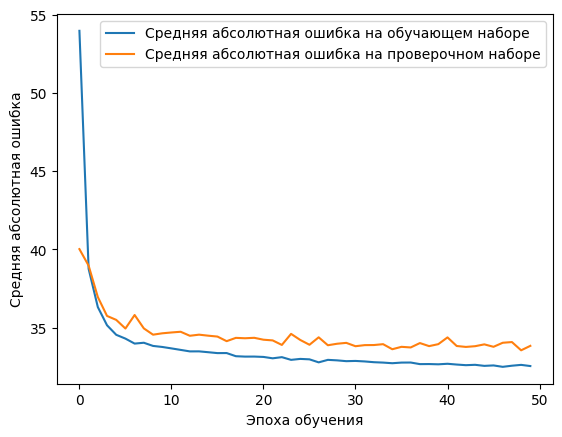

In [ ]:
# Обучаем модель полученными данными
model = Sequential()
model.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(1000, activation='tanh'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = model.fit(xTrain01,
                    yTrain,
                    epochs=50,
                    batch_size=32,
                    validation_split=0.15,
                    verbose=2)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
# Делаем предсказание и приводим его к начальному виду
pred = model.predict(xTrain01)
pred = pred.flatten()
# Среднее значение ошибки
delta = pred - yTrain
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
33.153204554674005


In [ ]:
# В качестве нормализации данных используем готовую библиотеку
yScaler = StandardScaler()

# Скармливаем объекту двумерный вектор
yScaler.fit(yTrain.reshape(-1, 1))

# Нормализуем по нормальному распределению
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1))

print(yTrainScaled.shape)
print(yTrain[1])
print(yTrainScaled[1])

(62967, 1)
40.0
[-0.3025949]


In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

0.001 24700.0
[-0.62864885] [200.71469124]


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/normalization/batch_normalization.py:142: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


837/837 - 6s - 7ms/step - loss: 1.0514 - mae: 0.2945 - val_loss: 0.1810 - val_mae: 0.2838
Epoch 2/50
837/837 - 2s - 3ms/step - loss: 1.0335 - mae: 0.2771 - val_loss: 0.1770 - val_mae: 0.2790
Epoch 3/50
837/837 - 2s - 2ms/step - loss: 1.0296 - mae: 0.2725 - val_loss: 0.1746 - val_mae: 0.2742
Epoch 4/50
837/837 - 2s - 2ms/step - loss: 1.0265 - mae: 0.2699 - val_loss: 0.1750 - val_mae: 0.2699
Epoch 5/50
837/837 - 3s - 4ms/step - loss: 1.0251 - mae: 0.2680 - val_loss: 0.1729 - val_mae: 0.2697
Epoch 6/50
837/837 - 4s - 5ms/step - loss: 1.0236 - mae: 0.2660 - val_loss: 0.1723 - val_mae: 0.2704
Epoch 7/50
837/837 - 2s - 3ms/step - loss: 1.0230 - mae: 0.2663 - val_loss: 0.1732 - val_mae: 0.2690
Epoch 8/50
837/837 - 2s - 3ms/step - loss: 1.0223 - mae: 0.2652 - val_loss: 0.1715 - val_mae: 0.2707
Epoch 9/50
837/837 - 2s - 3ms/step - loss: 1.0205 - mae: 0.2645 - val_loss: 0.1712 - val_mae: 0.2691
Epoch 10/50
837/837 - 3s - 3ms/step - loss: 1.0205 - mae: 0.2643 - val_loss: 0.1708 - val_mae: 0.2698


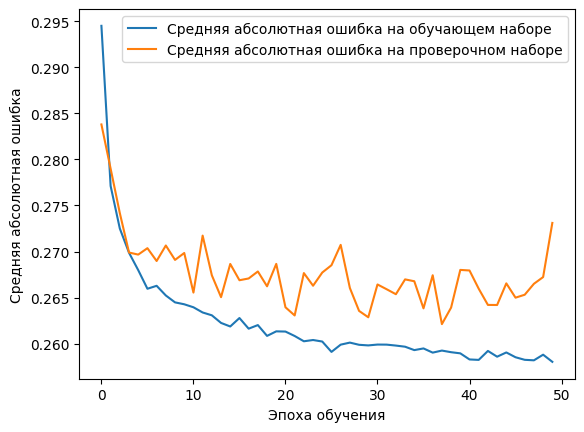

In [ ]:
# Обучаем модель стандартизированными данными
modelS = Sequential()
modelS.add(BatchNormalization(input_shape=(xTrain01.shape[1],)))
modelS.add(Dense(128, activation='relu'))
modelS.add(Dense(1000, activation='tanh'))
modelS.add(Dense(100, activation='relu'))
modelS.add(Dense(1, activation='linear'))

modelS.compile(optimizer=Adam(learning_rate=1e-5), loss='mse', metrics=['mae'])

history = modelS.fit(xTrain01,
                    yTrainScaled,
                    epochs=50,
                    batch_size=64,
                    validation_split=0.15,
                    verbose=2)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
# Делаем предсказание и приводим его к начальному виду
pred = modelS.predict(xTrain01)
predUnscaled = yScaler.inverse_transform(pred).flatten()

# Среднее значение ошибки
delta = predUnscaled - yTrain
absDelta = abs(delta)
print(sum(absDelta) / len(absDelta))

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
32.35504819423825


## Estimation of results


In [ ]:
yy = model.predict(xTrain01) # Результат для всего тренировочного набора

1968/1968 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


In [ ]:
n = 10
for i in range(n):
  print('Реальное значение - ',yTrain[i], " Предсказанное значение - ", yy[i][0], " Разница - ", abs(yTrain[i]-yy[i][0]))

Реальное значение -  40.0  Предсказанное значение -  40.297787  Разница -  0.2977867126464844
Реальное значение -  40.0  Предсказанное значение -  68.20978  Разница -  28.20977783203125
Реальное значение -  300.0  Предсказанное значение -  157.20227  Разница -  142.7977294921875
Реальное значение -  180.0  Предсказанное значение -  163.0683  Разница -  16.93170166015625
Реальное значение -  40.0  Предсказанное значение -  48.01076  Разница -  8.010761260986328
Реальное значение -  200.0  Предсказанное значение -  141.1344  Разница -  58.8656005859375
Реальное значение -  120.0  Предсказанное значение -  107.29972  Разница -  12.700279235839844
Реальное значение -  50.0  Предсказанное значение -  85.51483  Разница -  35.51483154296875
Реальное значение -  60.0  Предсказанное значение -  78.96157  Разница -  18.961570739746094
Реальное значение -  70.0  Предсказанное значение -  124.23137  Разница -  54.23136901855469


## Using simple text data


In [ ]:
# Выкачиваем данные по профессиям
def getXTrainTProf(values):
  xTrainTProf = []

  for val in values:
    currText = ""
    if (type(val[2]) != float):
      currText += val[2]
    if (type(val[7]) != float):
      currText += " " + val[7]

    xTrainTProf.append(currText)

  xTrainTProf = np.array(xTrainTProf)

  return xTrainTProf

In [ ]:
# Вытаскиваем професии для выборки
xTrainTProf = getXTrainTProf(fixed_df.values)
print(xTrainTProf[123]) # пример профессии 11го резюме

Аналитик Комсомольская правда, ИД


In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 10000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTProf) # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items())  #Вытаскиваем индексы слов для просмотра

In [ ]:
#преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainProfIndexes = tokenizer.texts_to_sequences(xTrainTProf) #обучающие тесты в индексы

## Creation of training and validation samples


In [ ]:
# Преобразовываем полученные выборки из последовательности индексов в матрицы нулей и единиц по принципу Bag of Words
xTrainProf01 = tokenizer.sequences_to_matrix(xTrainProfIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainProf01.shape)                                       # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainProf01[0][0:100])

(62967, 10000)
[0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


In [ ]:
n = 0
print(xTrainTProf[n])       # Профессия
print(xTrainProfIndexes[n]) # Профессия через индексы

Специалист по поддержке чата(support team) домашний агент ООО "Гольфстрим"
[4, 5, 219, 2300, 402, 139, 2976, 2006, 2, 1613]


In [ ]:
xTrainProf01.shape

(62967, 10000)

## NN training using the simple data


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 15802.7832 - mae: 64.2292 - val_loss: 4744.7231 - val_mae: 41.4252
Epoch 2/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 12231.8164 - mae: 40.4846 - val_loss: 3903.3291 - val_mae: 40.0149
Epoch 3/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 50163.9609 - mae: 41.5011 - val_loss: 3627.3877 - val_mae: 39.0970
Epoch 4/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 12060.4521 - mae: 38.5984 - val_loss: 3442.6492 - val_mae: 38.2907
Epoch 5/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 21170.9375 - mae: 38.7143 - val_loss: 3307.9272 - val_mae: 37.5328
Epoch 6/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 9s 4ms/step - loss: 8378.7344 - mae: 37.4293 - val_loss: 3201.0242 - val_mae: 36.9285
Epoch 7/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 6746.6626 - mae: 36.3823 - val_loss: 3114.7532 - val_mae: 36.4250
Epoch 8/50
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 14050.2891 - mae: 36.8277 - val_loss

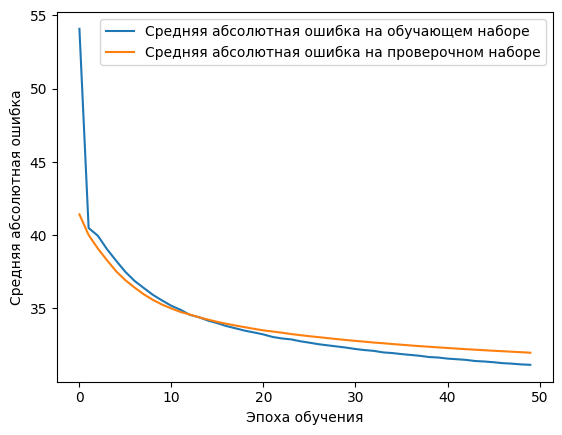

In [ ]:
# Предсказываем по предыдущей работе и желаемой
modelTProf = Sequential()
modelTProf.add(Dense(20, activation='relu', input_dim=(xTrainProf01.shape[1]) ) )
modelTProf.add(Dense(500, activation='relu'))
modelTProf.add(Dense(1, activation='linear'))

modelTProf.compile(optimizer=Adagrad(learning_rate=1e-3), loss='mse', metrics=['mae'])

history = modelTProf.fit(xTrainProf01[:50000],
                    yTrain[:50000],
                    batch_size=20,
                    epochs=50,
                    #validation_split=0.1,
                    validation_data=(xTrainProf01[50000:], yTrain[50000:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
del xTrainProf01 # Удаляем переменную, иначе дальше может вылететь из-за нехватки памяти

## Loading the complex text data

In [ ]:
# Выкачиваем данные по резюме
def getXTrainTRez(values):
  xTrainTRez = []

  for val in values:
    currText = ""
    if (type(val[6]) != float):
      currText += val[6]

    xTrainTRez.append(currText)

  xTrainTRez = np.array(xTrainTRez)

  return xTrainTRez

In [ ]:
# Вытаскиваем резюме для выборки
xTrainTRez = getXTrainTRez(fixed_df.values)

In [ ]:
print(xTrainTRez[10]) # Пример профессии 11го резюме

Опыт работы 27 лет 4 месяца  Программист 2 000 EUR Информационные технологии, интернет, телеком Программирование, Разработка Системная интеграция Занятость: полная занятость График работы: полный день Опыт работы 27 лет 4 месяца Январь 2008 — по настоящее время 11 лет 4 месяца Консалтинг КАС Главный аналитик Программирование на разных версиях RPG для AS/400 (iSeries). Модификация и доработка существующего кода, расширения функциональности системы. Разработка новых модулей и подсистем. Постановка задач, управление проектами. Январь 1993 — Январь  2008 15 лет 1 месяц Артекс, крупнейший дилер БМВ в Москве Директор по ИТ Доработка существующей системы управления дилерским предприятием (AS/400, iSeries). Все версии RPG (RPG36, RPG400, ILE RPG). Работа с DB2. Расширение функциональности системы, изменение системы, согласно действующему законодательству РФ. Руководство проектами, координация действий различных подразделений компании и сторонних организаций. Бюджетирование. Исследование бизнес

In [ ]:
#################
#Преобразовываем текстовые данные в числовые/векторные для обучения нейросетью
#################

maxWordsCount = 5000 #определяем макс.кол-во слов/индексов, учитываемое при обучении текстов

#для этого воспользуемся встроенной в Keras функцией Tokenizer для разбиения текста и превращения в матрицу числовых значений
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
#выше задаем параметры:
#(num_words=maxWordsCount) - определяем макс.кол-во слов/индексов, учитываемое при обучении текстов
#(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n') - избавляемся от ненужных символов
#(lower=True) - приводим слова к нижнему регистру
#(split=' ') - разделяем слова по пробелу
#(char_level=False) - просим токенайзер не удалять однобуквенные слова

tokenizer.fit_on_texts(xTrainTRez)         # "скармливаем" наши тексты, т.е даём в обработку методу, который соберет словарь частотности
items = list(tokenizer.word_index.items()) # Вытаскиваем индексы слов для просмотра

In [ ]:
# Преобразовываем текст в последовательность индексов согласно частотному словарю
xTrainRezIndexes = tokenizer.texts_to_sequences(xTrainTRez) # Обучающие тесты в индексы

## Creation of testsing and validation samples

Functions for sample formation using the text extracts with pre-set pitch

Data conditioning

In [ ]:
xTrainRez01 = tokenizer.sequences_to_matrix(xTrainRezIndexes) # Подаем xTrain в виде списка чтобы метод успешно сработал
print(xTrainRez01.shape)                                      # Размер обучающей выборки, сформированной по Bag of Words
print(xTrainRez01[0][0:100])

In [ ]:
print(xTrainRez01.shape) # Размер выборки самых частых слов
print(xTrainRez01[555]) # Пример из отформатированной выборки

## NN training using the complex text data


In [ ]:
# здесь в параметрах maxWordCount = 2000
modelTRez = Sequential()
modelTRez.add(Dense(20, activation='relu',input_dim=(xTrainRez01.shape[1])))
modelTRez.add(Dense(500, activation='relu'))
modelTRez.add(Dropout(0.3))
modelTRez.add(Dense(1, activation='linear'))

modelTRez.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])

history = modelTRez.fit(xTrainRez01[:50000],
                    yTrain[:50000],
                    batch_size=20,
                    epochs=20,
                    validation_data=(xTrainRez01[50000:], yTrain[50000:]),
                    verbose=1, shuffle=True)

plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

## Composite NN


In [ ]:
input1 = Input((xTrain01.shape[1],))
#input2 = Input((xTrainProf01.shape[1],))
input3 = Input((xTrainRez01.shape[1],))

x1 = BatchNormalization()(input1) # Создаем ветку х1
x1 = Dropout(0.5)(x1)
x1 = Dense(10, activation="relu")(x1)
x1 = Dense(1000, activation="relu")(x1)
x1 = Dense(100, activation = "relu")(x1)

#x2 = BatchNormalization()(input2) # Создаем ветку х2
#x2 = Dense(25, activation="relu")(input2)
#x2 = Dense(8, activation="tanh")(x2)
#x2 = Dense(5, activation = "elu")(x2)

#x3 = BatchNormalization()(input3) # Создаем ветку х3
x3 = Dense(1000, activation="tanh")(input3)
x3 = Dense(20, activation = "elu")(x3)
x3 = Dense(5, activation = "elu")(x3)

x = concatenate([x1, x3]) # Объединяем все три ветки

x = Dense(15, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='relu')(x) # Финальный нейрон, делает регрессию

model = Model((input1, input3), x) # В Model загружаем стартовые и последнюю точки

model.compile(optimizer=Adam(lr=1e-3), loss='mse', metrics=['mae'])

history = model.fit([xTrain01[:50000], xTrainRez01[:50000]],
                    yTrain[:50000],
                    epochs= 80,
                    validation_data=([xTrain01[50000:], xTrainRez01[50000:]],
                    yTrain[50000:]),
                    verbose=1, shuffle=True)

In [ ]:
plt.plot(history.history['mae'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_mae'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

In [ ]:
yy = yTrain[50000:] # Зарплата
pred = model.predict([xTrain01[50000:], xTrainRez01[50000:]]) # Предсказанная зарплата
plt.scatter(yy, pred)
plt.xlabel('Правильные значение')
plt.ylabel('Предсказания')
plt.axis('equal')
plt.xlim(plt.xlim())
plt.ylim(plt.ylim())
plt.plot([-1000, 1000], [-1000, 1000])
plt.show()

In [ ]:
del xTrainRez01, xTrainRezIndexes # Удаляем некоторые переменные, иначе дальше может вылететь из-за нехватки памяти

# Estimate of apartment cost



In [ ]:
df = pd.read_csv('/content/drive/My Drive/Базы/moscow.csv', sep=";") #Загружаем данные в data frame
df = df.iloc[::2,:] #Выбираем нечётные строки, в чётных строках в исходном фрейме пустые строки для комментариев
data = df.values #Вытаскиваем данные в numpy array

In [ ]:
df.head(20) #Показываем пример данных (первые 6 колонок)

In [ ]:
print(df.columns) #Показываем имена колонок данных
#Мы будем использовать

#В xTrain - база числовых значени
#Комнат
#Метро / ЖД станции
#От станции
#Дом
#Балкон
#Санузел
#Площадь

#В xTrainC - база текстов о квартирах
#Примечание

#В yTrain
#Цена, руб.

#Остальные колонки игнорируем

##Функции парсинга

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=2126

In [ ]:
#Во всех функция дальше
#d - описание квартиры, одна строка из data1

#Вычисляем количество комнат
#maxRoomCount - максимальное число комнат в квартире
def getRoomsCount(d, maxRoomCount):
  roomsCountStr = d[0] #Получаем строку с числом комнат

  roomsCount = 0
  try:
    roomsCount = int(roomsCountStr) #Пробуем превратить строку в число
    if (roomsCount > maxRoomCount):
      roomsCount = maxRoomCount #Если число комнат больше максимального, то присваиваем максимальное
  except: #Если не получается превратить строку в число
    if (roomsCountStr == roomsCountStr): #Проверяем строку на nan (сравнение с самим собой)
      if ("Ст" in roomsCountStr): #Еcть строка = "Ст", значит это Студия
        roomsCount = maxRoomCount + 1

  return roomsCount

#Превращаем число комнат в категорию
def getRoomsCountCategory(d, maxRoomCount):
  roomsCount = getRoomsCount(d, maxRoomCount) #Получаем число комнат
  roomsCount = utils.to_categorical(roomsCount, maxRoomCount+2) #Превращаем в категорию
  #maxRoomCount+2 потому что 0 зарезервирован на неопознаное число комнат, а maxRoomCount+1 на "Студию"
  return roomsCount

#Получаем индекс станции метро
#allMetroNames - все уникальные названия метро в базе
def getMetro(d, allMetroNames):
  metroStr = d[1] #Получаем строку метро
  metro = 0

  if (metroStr in allMetroNames): #Если находим метро во всех названиях
    metro = allMetroNames.index(metroStr)+1 #Присваиваем индекс
    #+1 так как 0 зарезервирован на неопознанное метро

  return metro

#Получаем тип метро
#0 - внутри кольца
#1 - кольцо
#2 - 1-3 станции от конца
#3 - 4-8 станций от кольца
#4 - больше 8 станций от кольца
def getMetroType(d):
  metroTypeStr = d[1] #Получаем строку метро
  metroTypeClasses = 5 #Число классов метро
  metroType = metroTypeClasses - 1 #Изначально считаем последний класс

  #Метро внутри кольца
  metroNamesInsideCircle = ["Площадь Революции", "Арбатская", "Смоленская", "Красные Ворота", "Чистые пруды", "Лубянка", "Охотный Ряд", "Библиотека имени Ленина", "Кропоткинская", "Сухаревская", "Тургеневская", "Китай-город", "Третьяковская", "Трубная", "Сретенский бульвар", "Цветной бульвар", "Чеховская", "Боровицкая", "Полянка", "Маяковская", "Тверская", "Театральная", "Новокузнецкая", "Пушкинская", "Кузнецкий Мост", "Китай-город", "Александровский сад"]
  #Метро на кольце
  metroNamesCircle = ["Киевская", "Парк Культуры", "Октябрьская", "Добрынинская", "Павелецкая", "Таганская", "Курская", "Комсомольская", "Проспект Мира", "Новослободская", "Белорусская", "Краснопресненская"]
  #Метро 1-3 станции от кольца
  metroNames13FromCircle = ["Бауманская", "Электрозаводская", "Семёновская", "Площадь Ильича", "Авиамоторная", "Шоссе Энтузиастов", "Римская", "Крестьянская Застава", "Дубровка", "Пролетарская", "Волгоградский проспект", "Текстильщики", "Автозаводская", "Технопарк", "Коломенская", "Тульская", "Нагатинская", "Нагорная", "Шаболовская", "Ленинский проспект", "Академическая", "Фрунзенская", "Спортивная", "Воробьёвы горы", "Студенческая", "Кутузовская", "Фили", "Парк Победы", "Выставочная", "Международная", "Улица 1905 года", "Беговая", "Полежаевская", "Динамо", "Аэропорт", "Сокол", "Деловой центр", "Шелепиха", "Хорошёвская", "ЦСКА", "Петровский парк", "Савёловская", "Дмитровская", "Тимирязевская", "Достоевская", "Марьина Роща", "Бутырская", "Фонвизинская", "Рижская", "Алексеевская", "ВДНХ", "Красносельская", "Сокольники", "Преображенская площадь"]
  #Метро 4-8 станций от кольа
  metroNames48FromCircle = ["Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Партизанская", "Измайловская", "Первомайская", "Щёлковская", "Новокосино", "Новогиреево", "Перово", "Кузьминки", "Рязанский проспект", "Выхино", "Лермонтовский проспект", "Жулебино", "Улица Дмитриевского", "Кожуховская", "Печатники", "Волжская", "Люблино", "Братиславская", "Коломенская", "Каширская", "Кантемировская", "Царицыно", "Орехово", "Севастопольская", "Чертановская", "Южная", "Пражская", "Варшавская", "Профсоюзная", "Новые Черёмушки", "Калужская", "Беляево", "Коньково", "Университет", "Багратионовская", "Филёвский парк", "Пионерская", "Кунцевская", "Молодёжная", "Октябрьское Поле", "Щукинская", "Спартак", "Тушинская", "Сходненская", "Войковская", "Водный стадион", "Речной вокзал", "Беломорская", "Ховрино", "Петровско-Разумовская", "Владыкино", "Отрадное", "Бибирево", "Алтуфьево", "Фонвизинская", "Окружная", "Верхние Лихоборы", "Селигерская", "ВДНХ", "Ботанический сад", "Свиблово", "Бабушкинская", "Медведково", "Преображенская площадь", "Черкизовская", "Бульвар Рокоссовского"]

  #Проверяем, в какую категорию попадает наша станция
  if (metroTypeStr in metroNamesInsideCircle):
    metroType = 0
  if (metroTypeStr in metroNamesCircle):
    metroType = 1
  if (metroTypeStr in metroNames13FromCircle):
    metroType = 2
  if (metroTypeStr in metroNames48FromCircle):
    metroType = 3

  #Превращаем результат в категорию
  metroType = utils.to_categorical(metroType, metroTypeClasses)
  return metroType


#Вычисляем растояние до метро
def getMetroDistance(d):
  metroDistanceStr = d[2] #Получаем строку

  metroDistance = 0 #Расстояние до метро
  metroDistanceType = 0 #Тип расстояния - пешком или на транспорте

  #ЕСли строка не равна nan
  if (metroDistanceStr == metroDistanceStr):
    if (len(metroDistanceStr) > 0):
      #Определяем тип расстояния
      if (metroDistanceStr[-1] == "п"):
        metroDistanceType = 1 #Пешком
      elif (metroDistanceStr[-1] == "т"):
        metroDistanceType = 2 #На транспорте

      #Выбрасываем последний символ, чтобы осталось только число
      metroDistanceStr = metroDistanceStr[:-1]
      try:
        #Разделяем дистанции на категории
        metroDistance = int(metroDistanceStr)
        if (metroDistance < 3):
          metroDistance = 1
        elif (metroDistance < 6):
          metroDistance = 2
        elif (metroDistance < 10):
          metroDistance = 3
        elif (metroDistance < 15):
          metroDistance = 4
        elif (metroDistance < 20):
          metroDistance = 5
        else:
          metroDistance = 6
      except: #Если в строке не число, то категория 0
        metroDistance = 0

  #Число классов дистанции
  metroDistanceClasses = 7

  #У нас 7 категорий дистанции по расстоянию
  #И 3 типа дистанции - неопознанный, пешком и транспортом
  #Мы создадим вектор длины 3*7 = 21
  #Будем преобразовывать индекс расстояния 0-6 в 0-20
  #Для типа "Пешком" - ничего не меняем
  if (metroDistanceType == 2):
    metroDistance += metroDistanceClasses #Для типа "Транспортом" добавляем 7
  if (metroDistanceType == 0):
    metroDistance += 2*metroDistanceClasses #Для неопознанного типа добавляем 14

  #Превращаем в категории
  metroDistance = utils.to_categorical(metroDistance, 3*metroDistanceClasses)
  return metroDistance

#Получаем 4 данных
#- этаж квартиры
#- этажность дома
#- индикатор, что последний этаж
#- тип дома
def getHouseTypeAndFloor(d):
  try:
    houseStr = d[3] #Получаем строку типа дома и этажей
  except:
    houseStr = ""

  houseType = 0 #Тип дома
  floor = 0 #Этаж квартиры
  floors = 0 #Этажность дома
  isLastFloor = 0 #Индикатор последнего этажа

  #Проверяем строку на nan
  if (houseStr == houseStr):
    if (len(houseStr) > 1):

      try:
        slashIndex = houseStr.index("/") #Ищем разделитель /
      except:
        print(houseStr)

      try:
        spaceIndex = houseStr.index(" ") #Ищем разделитель " "
      except:
        print(houseStr)

      #Вытаскиваем строки
      floorStr = houseStr[:slashIndex] #Строка этажа
      floorsStr = houseStr[slashIndex+1:spaceIndex] #Строка этажнгости дома
      houseTypeStr = houseStr[spaceIndex+1:] #Строка типа дома

      #Выбираем категорию этажа
      try:
        floor = int(floorStr) #Превращаем строку в число
        floorSave = floor
        if (floorSave < 5):
          floor = 2
        if (floorSave < 10):
          floor = 3
        if (floorSave < 20):
          floor = 4
        if (floorSave >= 20):
          floor = 5
        if (floorSave == 1): #Первый этаж выделяем в отдельную категорию
          floor = 1

        if (int(floorStr) == int(floorsStr)): #Если этаж последний, включаем индикатор последнего этажа
          isLastFloor = 1
      except:
        floor = 0 #Если строка не парсится в число, то категория этажа = 0 (отдельная)

      #Выбираем категорию этажности дома
      try:
        floors = int(floorsStr) #Превращаем строку в число
        floorsSave = floors
        if (floorsSave < 5):
          floors = 1
        if (floorsSave < 10):
          floors = 2
        if (floorsSave < 20):
          floors = 3
        if (floorsSave >= 20):
          floors = 4
      except:
        floors = 0 #Если строка не парсится в число, то категория этажности = 0 (отдельная)

      #Определяем категорию типа дома
      if (len(houseTypeStr) > 0):
        if ("М" in houseTypeStr):
          houseType = 1
        if ("К" in houseTypeStr):
          houseType = 2
        if ("П" in houseTypeStr):
          houseType = 3
        if ("Б" in houseTypeStr):
          houseType = 4
        if ("?" in houseTypeStr):
          houseType = 5
        if ("-" in houseTypeStr):
          houseType = 6

    #Превращаем все категории в one hot encoding
    floor = utils.to_categorical(floor, 6)
    floors = utils.to_categorical(floors, 5)
    houseType = utils.to_categorical(houseType, 7)


  return floor, floors, isLastFloor, houseType


#Вычисляем тип балкона
def getBalcony(d):
  balconyStr = d[4] #Полуаем строку
  #Выписываем все варианты балконов в базе
  balconyVariants = ['Л', 'Б', '2Б', '-', '2Б2Л', 'БЛ', '3Б', '2Л', 'Эрк', 'Б2Л', 'ЭркЛ', '3Л', '4Л', '*Л', '*Б']
  #Проверяем на nan
  if (balconyStr == balconyStr):
    balcony = balconyVariants.index(balconyStr)+1 #Находим индекс строки балкона во всех строках
  else:
    balcony = 0 #Индекс 0 выделяем на строку nan

  #Превращаем в one hot encoding
  balcony = utils.to_categorical(balcony, 16)

  return balcony

#Определяем тип санузла
def getWC(d):
  wcStr = d[5] #Получаем строку
  #Выписываем все варианты санузлов в базе
  wcVariants = ['2', 'Р', 'С', '-', '2С', '+', '4Р', '2Р', '3С', '4С', '4', '3', '3Р']
  #Проверяем на nan
  if (wcStr == wcStr):
    wc = wcVariants.index(wcStr)+1 #Находим индекс строки санузла во всех строках
  else:
    wc = 0 #Индекс 0 выделяем на строку nan

  #Превращаем в one hot encoding
  wc = utils.to_categorical(wc, 14)

  return wc

#Определяем площадь
def getArea(d):
  areaStr = d[6] #Поулачем строку площади

  if ("/" in areaStr):
    slashIndex = areaStr.index("/") #Находим разделитель /
    try:
      area = float(areaStr[:slashIndex]) #Берём число до разделителя и превращаем в число
    except:
      area = 0 #Если не получается, возвращаем 0
  else:
    area = 0 #Или если нет разделителя, возвращаем 0

  return area

#Получаем цену
def getCost(d):
  costStr = d[7] #Загружаем строку

  try:
    cost = float(costStr) #Пробуем превратить в число
  except:
    cost = 0 #Если не получается, возвращаем 0

  return cost

#Получаем комментарий
def getComment(d):
  commentStr = d[-1] #Возвращаем данные из последней колонки

  return commentStr

#Объединяем все числовые параметры вместе
def getAllParameters(d, allMetroNames):
  #Загружаем все данные по отдельности
  roomsCountType = getRoomsCountCategory(d, 30)
  metro = getMetro(d, allMetroNames)
  metroType = getMetroType(d)
  metroDistance = getMetroDistance(d)
  floor, floors, isLastFloor, houseType = getHouseTypeAndFloor(d)
  balcony = getBalcony(d)
  wc = getWC(d)
  area = getArea(d)

  #Объединяем в один лист
  out = list(roomsCountType)
  out.append(metro)
  out.extend(metroType)
  out.extend(metroDistance)
  out.extend(floor)
  out.extend(floors)
  out.append(isLastFloor)
  out.extend(houseType)
  out.extend(balcony)
  out.extend(wc)
  out.append(area)

  return out

#Генерируем обучающаюу выборку - xTrain
def getXTrain(data):

  #Получаем строку во всеми вариантами метро
  allMertroNames = list(df["Метро / ЖД станции"].unique())

  #Всевращаем все строки в data1 в векторы параметров и записываем в xTrain
  xTrain = [getAllParameters(d, allMertroNames) for d in data]
  xTrain = np.array(xTrain)

  return xTrain

#Генерируем обучающую выборку - yTrain
def getYTrain(data):

  #Зашружаем лист всех цен квартир по всем строкам data1
  costList = [getCost(d) for d in data]
  yTrain = np.array(costList)

  return yTrain

##Формируем обучающую выборку

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=2867



In [ ]:
oneRoomMask = [getRoomsCount(d, 30) == 1 for d in data] #Делаем маску однокомнатных квартир, принцип (getRoomsCount(d, 30) == 1)
data1 = data[oneRoomMask] #В data1 оставляем только однокомнатные квартиры
print(data.shape)
print(data1.shape)

In [ ]:
xTrain = getXTrain(data1)
yTrain = getYTrain(data1)

In [ ]:
print(xTrain.shape)

##Парсинг текста

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=2924

In [ ]:
###########################
# Очистка текста и превращение в набор слов
##########################
def text2Words(text):

  #Удаляем лишние символы
  text = text.replace(".", "")# удаляем лишние символы
  text = text.replace("—", "")
  text = text.replace(",", "")
  text = text.replace("!", "")
  text = text.replace("?", "")
  text = text.replace("…", "")
  text = text.lower() #Переводим в нижний регистр


  words = [] #Тут будут все слов
  currWord = "" #Тут будет накапливаться текущее слово, между двумя пробелами

  #идём по всем символам
  for symbol in text:

    if (symbol != "\ufeff"): #Игнорируем системынй символ в начале строки
      if (symbol != " "): #Если символ не пробел
        currWord += symbol #То добавляем вимвол в текущее слово
      else: #Если символ пробел
        if (currWord != ""):
          words.append(currWord) #Добавляем тккущее слово в список слов
          currWord = "" #И обнуляем текущее слово

  #Добавляем финальное слово, если оно не пустое
  #Если не сделать, то потеряем финальное слово, потому что текст чаще всего заканчивается на не пробел
  if (currWord != ""):
        words.append(currWord)

  return words


###########################
# Создание словаря - все слова, упорядоченные по частоте появления
##########################
def createVocabulary(allWords):

  #Создаём словарь, в котором будут слова и количество их поялвений во всём текста
  #Ключи - все наши слова
  #Количество появлений пока везде 0
  wCount = dict.fromkeys(allWords, 0)

  #Проходим по всем словам
  for word in allWords:
    wCount[word] += 1 #И увеличиаем количество появлений текущего слова на 1

  #Выцепляем лист из словаря
  wordsList = list(wCount.items())
  #И сортируем по частоте появления
  wordsList.sort(key = lambda i:i[1], reverse=1)
  #key = lambda i:i[1] - говорит, что сортировать надо по частоте появления
  #В i[0] у нас слово, в i[1] - частота появления
  #reverse=1 говорить сортироваться по убыванию

  sortedWords = [] #Тут будет лист всех отсортированных слов

  #Проходим по всем словам в отсортированном списке
  for word in wordsList:
    sortedWords.append(word[0]) #Докидываем слово в лист отсортированных слов

  #Это словарь слово - индекс
  #Изначально заполнен всеми словами
  #У всех индекс 0
  wordIndexes = dict.fromkeys(allWords, 0)
  #Проходим по всем словам
  for word in wordIndexes.keys():
    wordIndexes[word] = sortedWords.index(word)+1 #Ставим индекс = индекс слова в отсортированном листе слов + 1
    #+1 потому, что индекс 0 резервируем под неопознанные слова

  return wordIndexes


###########################
# Преобразования листа слов в лист индексов
##########################
def words2Indexes(words, vocabulary, maxWordsCount):
  wordsIndexes = []

  #Идём по всем словая
  for word in words:

    wordIndex = 0 #Тут будет индекс слова, изначально 0 - слово неопознано
    wordInVocabulary = word in vocabulary #Проверяем, есть ли слово в словаре

    #Если слово есть в словаре
    if (wordInVocabulary):
      index = vocabulary[word] #Индекс = индексу слова в словаре
      if (index < maxWordsCount): #Если индекс ниже maxWordsCount - черты отсечения слов
        wordIndex = index #То записываем индекс
      #Иначе останется значение 0

    wordsIndexes.append(wordIndex)

  return wordsIndexes


###########################
# Преобразование одного короткого вектора в вектор из 0 и 1
# По принципу words bag
##########################
def changeXTo01(trainVector, wordsCount):
  #Создаём вектор длины wordsCount с нулями
  out = np.zeros(wordsCount)

  #Идём по всем индексам в строке
  for x in trainVector:
    out[x] = 1 #В позицию нужного индекса ставим 1

  return out


###########################
# Преобразование выборки (обучающей или проверочной) к виду 0 и 1
# По принципу words bag
##########################
def changeSetTo01(trainSet, wordsCount):
  out = []

  #Проходим по всем векторам в наборе
  for x in trainSet:
    out.append(changeXTo01(x, wordsCount)) #Добавляем в итоговый набор текущий вектор, преобразованный в bag of words

  return np.array(out)


###########################
# Формируем обучающую выборку из примечаний к квартирам
# Пока в виде слов
##########################
def getXTrainComments(data):
  xTrainComments = [] #Тут будет обучающся выборка
  allTextComments = "" #Тут будуте все тексты вместе для словаря

  #Идём по всем строкам квартир в базе
  for d in data:
    currText = getComment(d) #Вытаскиваем примечание к квартире
    try:
      if (currText == currText): #Проверяем на nan
        allTextComments += currText + " " #Добавляем текст в общий текст для словаря
    except:
      currText = "Нет комментария" #Если не получается, то делаем стандартный текст "Нет комментария"
    xTrainComments.append(currText) #Добавляем примечание новой строкой в обучающую выборку

  xTrainComments = np.array(xTrainComments)

  return (xTrainComments, allTextComments)

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
##########################
def changeSetToIndexes(xTrainComments, vocabulary, maxWordsCount):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов

  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain

  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = changeSetTo01(xTrainCommentsIndexes, maxWordsCount) #Превращаем в формат bag of words
  return xTrainCommentsIndexes

###########################
# Формируем обучающую выборку из примечаний к квартирам
# Теперь в виде индексов
# И с приведением к стандартной длине всех векторов - cropLen
##########################
def changeSetToIndexesCrop(xTrainComments, vocabulary, maxWordsCount, cropLen):
  xTrainCommentsIndexes = [] #Тут будет итоговый xTrain примечаний в виде индексов

  #Идём по всем текстам
  for text in xTrainComments:
    currWords = text2Words(text) #Разбиваем текст на слова
    currIndexes = words2Indexes(currWords, vocabulary, maxWordsCount) #Превращаем в лист индексов
    currIndexes = np.array(currIndexes)
    xTrainCommentsIndexes.append(currIndexes) #Добавляем в xTrain

  xTrainCommentsIndexes = np.array(xTrainCommentsIndexes)
  xTrainCommentsIndexes = pad_sequences(xTrainCommentsIndexes, maxlen=cropLen) #Приводим все вектора к стандартной длине
  return xTrainCommentsIndexes

##Собираем xTrain по текстам

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=2983


In [ ]:
xTrainC, allTextComments = getXTrainComments(data1) #Создаём обучающую выборку по текстам и большо текст для словаря
allWords = text2Words(allTextComments) #Собираем полный текст в слова
allWords = allWords[::10] #Берём 10% слов (иначе словарь слишком долго формируется)
vocabulary = createVocabulary(allWords) #Создаём словарь
xTrainC01 = changeSetToIndexes(xTrainC, vocabulary, 2000) #Преобразеум xTrain в bag of words

In [ ]:
#Выводим раземры обучающей выборки
#Чтобы проверить, что мы всё правильно собрали
print(xTrain.shape)
print(xTrainC01.shape)
print(yTrain.shape)

##Нормировка данных

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=3003


In [ ]:
#Нормируем размер квартиры в xTrain
xScaler = StandardScaler() #Создаём нормировщик нормальным распределением
xScaler.fit(xTrain[:,-1].reshape(-1, 1)) #Обучаем его на площадях квартир (последня колонка в xTrain)
xTrainScaled = xTrain.copy()
xTrainScaled[:,-1] = xScaler.transform(xTrain[:,-1].reshape(-1, 1)).flatten() #Нормируем данные нормировщиком

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(xTrainScaled.shape)
print(xTrain[0])
print(xTrainScaled[0])

In [ ]:
#Нормируем выход сети - цену квартиры
yScaler = StandardScaler() #Делаемнормальный нормировщик
yScaler.fit(yTrain.reshape(-1, 1)) #Обучаем на ценах квартир
yTrainScaled = yScaler.transform(yTrain.reshape(-1, 1)) #Нормируем цены квартир

#Выводим размер и два примера для сравнения
#Не нормированных данных и нормированных
print(yTrainScaled.shape)
print(yTrain[0])
print(yTrainScaled[0])

In [ ]:
print(min(yTrain), max(yTrain))
print(min(yTrainScaled), max(yTrainScaled))

Формируем проверочную выборку

In [ ]:
splitVal = 0.2 #Процент, который выделяем в проверочную выборку
valMask = np.random.sample(xTrainScaled.shape[0]) < splitVal #Создаём маску True-False для создания проверочной выборки

In [ ]:
np.save('/content/drive/My Drive/AIFramework/xTrainScaled',xTrainScaled)
np.save('/content/drive/My Drive/AIFramework/xTrainC01',xTrainC01)
np.save('/content/drive/My Drive/AIFramework/yTrainScaled',yTrainScaled)

##Нейронка

*Разбор данного раздела:* https://youtu.be/h8cOCvlYmN8?t=3176

In [ ]:
def on_epoch_end(epoch, logs):
  pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочно выборке
  predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
  yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
  delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
  absDelta = abs(delta) #Берём модуль отклонения
  print("Эпоха", epoch, "модуль ошибки", round(sum(absDelta) / (1e+6 * len(absDelta)),3)) #Выводим усреднённую ошибку в миллионах рублей

# Коллбэки
pltMae = LambdaCallback(on_epoch_end=on_epoch_end)

In [ ]:
print(type(xTrainScaled))
print(type(xTrainC01))
print(type(yTrainScaled))

In [ ]:
#Простая Dense сеть
input1 = Input((xTrainScaled.shape[1],))
input2 = Input((xTrainC01.shape[1],))

x1 = Dense(10, activation="relu")(input1)
x2 = Dense(250, activation="relu")(input2)

x = concatenate([x1, x2])

x = Dense(100, activation='relu')(x)
x = Dense(10, activation='relu')(x)
x = Dense(1, activation='linear')(x)

model = Model((input1, input2), x)

model.compile(optimizer=Adam(lr=1e-3), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=40,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-4')
model.compile(optimizer=Adam(lr=1e-4), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=200,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae])

print()
print('Меняем шаг обучения на 1e-5')
model.compile(optimizer=Adam(lr=1e-5), loss='mse')
history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
                    yTrainScaled[~valMask],
                    epochs=200,
                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
                    yTrainScaled[valMask]),
                    verbose=0,
                    callbacks=[pltMae])

#print()
#print('Меняем шаг обучения на 1e-6')
#model.compile(optimizer=Adam(lr=1e-6), loss='mse')
#history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
#                    yTrainScaled[~valMask],
#                    epochs=40,
#                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
#                    yTrainScaled[valMask]),
#                    verbose=0,
#                    callbacks=[pltMae])

#print()
#print('Меняем шаг обучения на 1e-7')
#model.compile(optimizer=Adam(lr=1e-7), loss='mse')
#history = model.fit([xTrainScaled[~valMask], xTrainC01[~valMask]],
#                    yTrainScaled[~valMask],
#                    epochs=40,
#                    validation_data=([xTrainScaled[valMask], xTrainC01[valMask]],
#                    yTrainScaled[valMask]),
#                    verbose=0,
#                    callbacks=[pltMae])




#Проверяем результаты
pred = model.predict([xTrainScaled[valMask], xTrainC01[valMask]]) #Полуаем выход сети на проверочной выборке
predUnscaled = yScaler.inverse_transform(pred).flatten() #Делаем обратное нормирование выхода к изначальным величинам цен квартир
yTrainUnscaled = yScaler.inverse_transform(yTrainScaled[valMask]).flatten() #Делаем такое же обратное нормирование yTrain к базовым ценам
delta = predUnscaled - yTrainUnscaled #Считаем разность предсказания и правильных цен
absDelta = abs(delta) #Берём модуль отклонения
print("Модуль ошибки", sum(absDelta) / (1e+6 * len(absDelta))) #Выводим усреднённую ошибку в миллионах рублей

#ВЫводим графики ошибки
plt.plot(history.history['loss'],
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'],
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Средняя абсолютная ошибка')
plt.legend()
plt.show()

# Forecast of the game result using the intermediate result

In [ ]:
df = pd.read_csv('/content/drive/My Drive/Базы/basketball.csv', encoding= 'cp1251', sep=';', header=0, index_col=0) # Загружаем базу
print (df.shape) # Смотрим размер базы
df.head(30) # Смотрим что в ней есть

Total - предсказание алгоритма владельцев базы. Info - данные о матче. Ком.1 и Ком.2 - забитые мячи. Минута и Секунда - прошедшее время тайма. Fcount - финальный результат игры - именно его нам надо предсказать. Ftime - прошедшее время игры в секундах без разбивки на таймы.

In [ ]:
Xtrain = np.array(df[['Ком. 1','Ком. 2', 'ftime']].astype('int')) # Преобразуем данные в numpy
Ytrain = np.array(df['fcount'].astype('int'))# Преобразуем данные в numpy

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(Xtrain, Ytrain, test_size=0.05) # Разбиваем по выборкам

In [ ]:
model = Sequential() # создаем простую модель
model.add(Dense(200,input_dim=3, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss="MAE", optimizer="adam") # можно использовать MAE (средняя абсолютная ошибка) или MSE(средняя квадратичная ошибка), результат примерно одинаковый

In [ ]:
history = model.fit(x_train, y_train,  # Обучаем сеть
                    batch_size=32,
                    epochs=60,
                    validation_data=(x_test, y_test),
                    verbose=1, shuffle=True)

In [ ]:
pred = model.predict(x_test)
for i in range(len(pred[:10])): # Выводим результаты
    print('Данные -',x_test[i],'  Предсказание - ',pred[i],'   Результат игры - ', y_test[i])

In [ ]:
def func_predict(data): # Простая функция линейной зависимости
    return (data[0]/data[2])*2400+(data[1]/data[2])*2400

func_pred=[] # создаем пустой список
for i in x_test: # в цикле заполняем списко предсказаниями функции на основе данных
    func_pred.append(round(func_predict(i)))

for i in range(len(x_test[:10])):# Выводим результаты
    print('Данные -',x_test[i],'  Предсказание сети- ',pred[i],' Предсказание функции' ,func_pred[i],'   Результат игры - ', y_test[i])

In [ ]:
err = mean_squared_error(y_test,pred) # Считаем MSE для предикта сети
err2 = mean_squared_error(y_test,func_pred)# Считаем MSE для предикта функции
avg_error = mean_absolute_error(y_test,pred)# Получаем среднюю абсолютную ошибку
print("MAE сети :", avg_error, 'MSE сети', err)# выводим ошибки сети
avg_error2 = mean_absolute_error(y_test,func_pred)#Получаем среднюю абсолютную ошибку
print("MAE функции :", avg_error2, 'MSE функции', err2)# выводим ошибки функции